## Introduction 

This notebook serves to carry out community detection on the user base in our datasets. 
It is to help further investigate users' preferences of movies in the notebook of "Communities Study". 

The purpose of this notebook is to form the communities and extract the user dictionaries for subsequent use.


### Import packages

In [1]:
import json
import re
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import Counter
import networkx as nx
from fa2 import ForceAtlas2
import nltk
import community
from wordcloud import WordCloud, STOPWORDS
import string
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from afinn import Afinn
import spacy
import random
from colour import Color
import operator
import math

plt.style.use('ggplot')
%matplotlib inline

In [0]:
master_movies_df = pd.read_csv('./datasets/movie_data_merged_v2.csv')
master_ratings_df_full = pd.read_csv('./datasets/user_ratings.csv')
user_demo_df = pd.read_csv('./datasets/users.csv').set_index("userid", drop=True)
del master_movies_df['Unnamed: 0']

### Build network

In [0]:
# Due to the nature of our dataset, we are using Undirected graph
# node - user, weight = with number of movies watched  
# edge - both user has reviewed the same movie 
g = nx.Graph()
user_movie_counts = master_ratings_df_full.groupby('user').size()

# Adding each unique users as nodes into graph
for user, count in user_movie_counts.items():
    g.add_node(user, size=count)

In [0]:
# get the all users who watched the same movies 
# grouped them by the movie IDs 
common_movie_users = master_ratings_df_full.groupby('movie')['user'].apply(list)

In [0]:
# get the edges and weight of each edge -- number of movies which both users watched in common
edgelist = {}
for movie, users in common_movie_users.items():
    lst = users
    
    for i in range(len(lst)):
        for j in range(0, len(lst)):
            if lst[i] == lst[j]: 
                continue
            if lst[i] not in edgelist.keys():
                edgelist[lst[i]] = []
                edgelist[lst[i]].append(lst[j])
            else:
                edgelist[lst[i]].append(lst[j])

In [0]:
# add the edges with weights
# Since we have all the neighbors which current user is connected with, 
# we can use Counter and get the total count of those users respectively. 
for curr_user, neighbours in edgelist.items():
    edge_weights = Counter(neighbours) # count of each user which current node is connected to
    
    for user, count in edge_weights.items():
        # add edge between 2 users with the count as weight
        g.add_edge(curr_user, user, weight=count)

In [0]:
# finding positions of the nodes using force atlas algorithm
f2 = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,

                # Tuning
                scalingRatio=2,
                strongGravityMode=False,
                gravity=0,

                # Log
                verbose=False)

positions_g = f2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


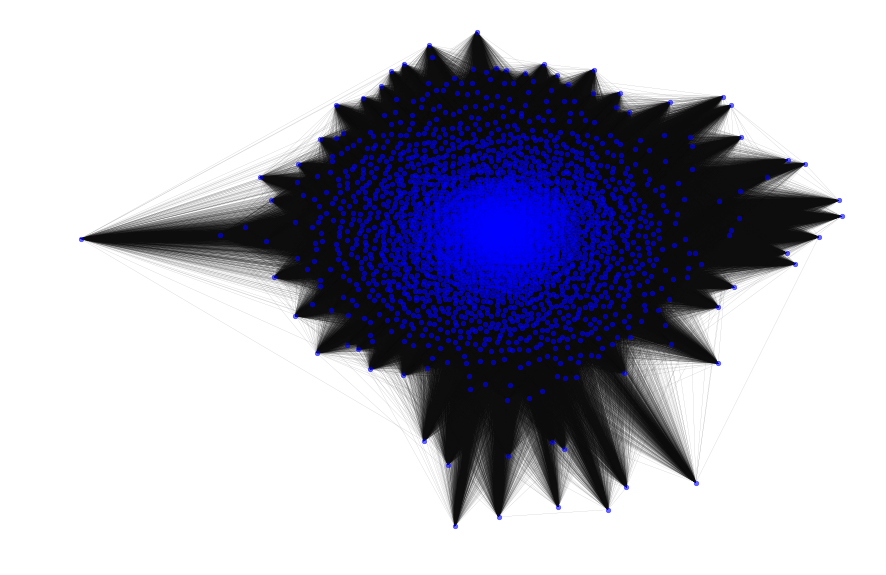

In [0]:
plt.figure(figsize=(15,10))
nx.draw_networkx(g, 
                 pos = positions_g, 
                 width = 0.1, 
                 alpha=0.6, 
                 cmap=plt.get_cmap('jet'),
                 node_color='blue',
                 node_size=22, 
                 edge_size=90, 
                 with_labels=False)
plt.axis('off')
plt.show()

In [0]:
cc = nx.number_connected_components(g)
print("There are %d connected components in the review network." %cc)

There are 1 connected components in the review network.


<div class="alert alert-block alert-info">
    In this network, the **nodes** are the **audience/users** who rates each movie. Each pair of nodes have a **connection** if both users have **watched at least 1 similar movie**. From the network above, we see that all the nodes are connected in this network - all pairs of user has watched at least 1 same movie.
</div>

### Network Attributes

#### Number of nodes, Number of edges, Average degree

In [0]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3255
Number of edges: 5021853
Average degree: 3085.6240


<div class="alert alert-block alert-info">
The total number of nodes in our movie network is **3255** and the total number of edges is **5021853**. Each node has on average **3085** connections to other nodes. 
</div>

### Centralities Measures

#### Top 3 Nodes with Highest degrees

In [0]:
degree = list(g.degree())
degree = sorted(degree,key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Number of degree"]

for i in degree[0:3]:
    x.add_row([i[0], i[1]])

print(x)

+--------+------------------+
| UserId | Number of degree |
+--------+------------------+
|  2793  |       3254       |
|  2907  |       3254       |
|  2909  |       3254       |
+--------+------------------+


<div class="alert alert-block alert-info">
The top 3 nodes have equal number of degrees of **3254**. This means each pair of node has watched at least 1 common movie. 
</div>

#### Top 3 Nodes with Highest Degree Centrality

> Degree centrality is the most basic method of defining centrality, basing the centrality only on the number of neighbours a node has.

In [0]:
deg_cent = nx.degree_centrality(g)
deg_cent = sorted(deg_cent.items(), key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Degree centrality"]

for i in deg_cent[0:3]:
    x.add_row([i[0], i[1]])
    
print(x)

+--------+--------------------+
| UserId | Degree centrality  |
+--------+--------------------+
|  2793  | 0.9999999999999999 |
|  2907  | 0.9999999999999999 |
|  2909  | 0.9999999999999999 |
+--------+--------------------+


<div class="alert alert-block alert-info">
With a degree centrality close to 1, it means the top 3 nodes are likely to centre of the network. However we saw that each node is connected to every other nodes, thus each node can be the center of the network. 
</div>

#### Top 3 Nodes with Hightest Eigenvector Centrality

> The eigenvector centrality thesis read: A node is important if it is linked to by other important nodes. It is a measure of the influence of a node in a network. 

In [0]:
eigen = nx.eigenvector_centrality(g)
eigen_sorted = sorted(eigen.items(), key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Eigenvector centrality"]

for i in eigen_sorted[0:3]:
    x.add_row([i[0], i[1]])
    
print(x)

+--------+------------------------+
| UserId | Eigenvector centrality |
+--------+------------------------+
|  2793  |  0.018331657225262463  |
|  2907  |  0.018331657225262463  |
|  2909  |  0.018331657225262463  |
+--------+------------------------+


<div class="alert alert-block alert-info">
The top 3 nodes are observed to have a Eigenvector centrality close to 0. This means these nodes do not have any influence on other nodes. This can be said for all the nodes in our network since they are all connected to each other.  
</div>

---
### Community Detection

#### Get user list of each community 

In [0]:
# using community library to create communities from our network
communities_generator = community.best_partition(g)

# get the community index of each user
values = [communities_generator.get(node) for node in g.nodes()]

# the number of communities formed within network
size = float(len(set(communities_generator.values())))

In [0]:
# group userIds according to their assigned community index
nodes_in_coms = {}

for com in set(communities_generator.values()) :
    
    # get all the nodes belonging to a community 
    list_nodes = [nodes for nodes in communities_generator.keys() if communities_generator[nodes] == com]
    nodes_in_coms[com] = list_nodes

In [0]:
print("The number of communities in our network = %d." %size)

The number of communities in our network = 4.


C:\Users\kianh\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


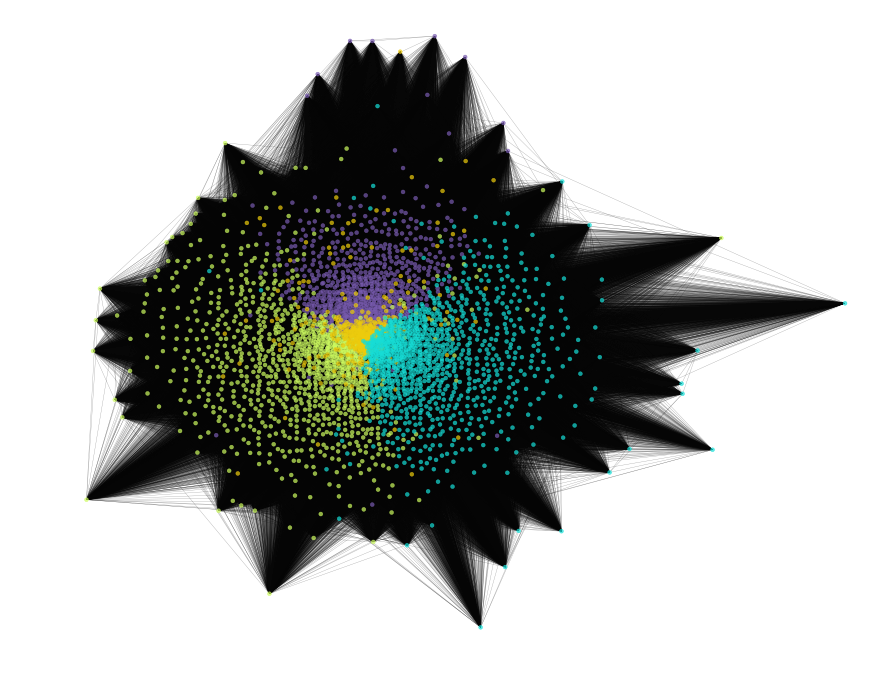

In [0]:
# Plotting out the different communities within the network
pos = nx.spring_layout(g)
count = 0

plt.figure(figsize=(15,12))

for com in set(communities_generator.values()) :
    count = count + 1.
    c = "#{:06x}".format(random.randint(0, 0xFFFFFF)) # generate color values
    color = []
    
    # get all the nodes belonging to a community 
    list_nodes = [nodes for nodes in communities_generator.keys()
                                if communities_generator[nodes] == com]
    
    for n in list_nodes: # color generator
        color.append(c)
        
    nx.draw_networkx_nodes(g, positions_g, list_nodes, node_size = 15, alpha=0.7,
                                node_color=color)


nx.draw_networkx_edges(g, pos = positions_g, alpha = 0.4, width = 0.3)

plt.axis('off')
plt.show()



<div class="alert alert-block alert-info">
    From the color codings, we see that there are 4 communities formed within our movie network. These communities should contain users with similar traits internally but maybe uniquely different among the communities.
</div>

---